# TODO

- implement visualization

In [29]:
import os
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [2]:
day = '2023-12-15'
time = '18-25-22'
base_path = os.path.join('hydra_output', day, time)

In [5]:
g = glob('final_output/*/*/*/seed*')[0]

In [6]:
g

'final_output\\2024-02-07\\19-21-12\\baseline\\seed1'

In [9]:
os.path.basename(g)

'seed1'

In [12]:
os.path.basename(os.path.dirname(g))

'baseline'

In [25]:
random_score = 719.1
human_score = 13_156.7
norm = lambda x, mn, mx: (x - mn) / (mx - mn)
human_norm = lambda x: norm(x, random_score, human_score)
dict_loop = lambda d, f: {key: f(value) for key, value in d.items()}

optimality_gamma = human_norm(human_score)

In [21]:
# Load calculated evaluation results from their respective files and store them in a dictionary. Also calculate the mean over evaluation episodes

mean_scores = {}
algos = ['baseline', 'cbp']
for algo in algos:
    seeds = sorted(glob(f'final_output/*/*/{algo}/seed*'))
    run_scores = []
    for seed in seeds:
        run_scores.append(np.load(os.path.join(seed, 'final_evaluation.npy'))[0].mean()) # only load scores, not episode lengths
    mean_scores[algo] = np.array(run_scores)[:, None]
mean_scores

{'baseline': array([[8900.],
        [3752.],
        [3577.]]),
 'cbp': array([[4218.],
        [4129.],
        [3732.]])}

In [22]:
scores_human = dict_loop(mean_scores, human_norm)

In [23]:
algos = sorted(scores_human.keys())

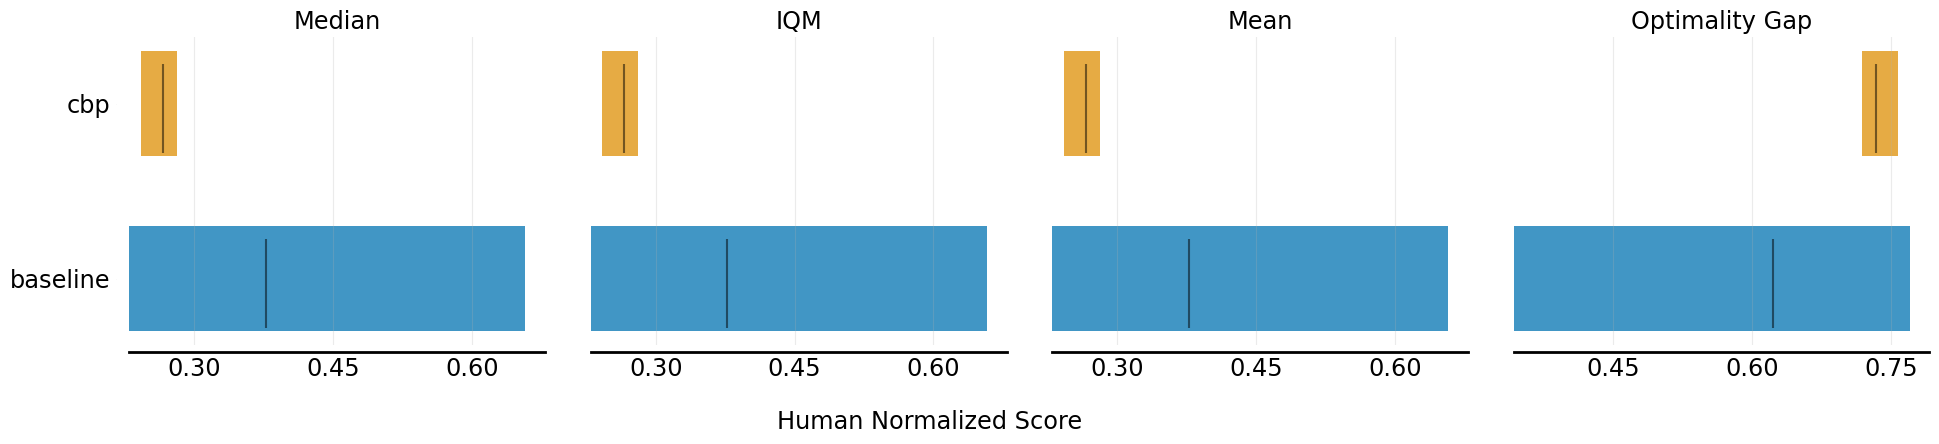

In [26]:
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x, optimality_gamma)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(scores_human, aggregate_func, reps=50000) # 50000

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=algos, xlabel='Human Normalized Score',
  subfigure_width=5, row_height=2)

<Axes: xlabel='P(X > Y)', ylabel='Algorithm X'>

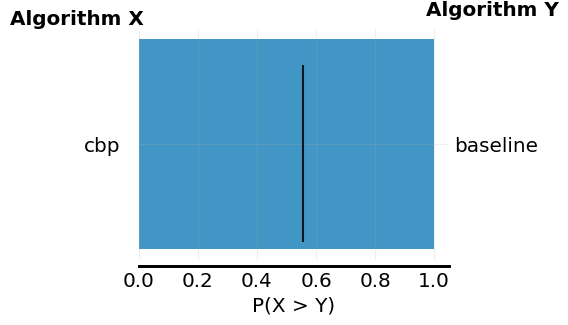

In [27]:
algorithm_pairs = {'cbp,baseline': (scores_human['cbp'], scores_human['baseline'])}
average_probabilities, average_prob_cis = rly.get_interval_estimates(
  algorithm_pairs, metrics.probability_of_improvement, reps=2000)
plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis, xticks=[0., 0.2, 0.4, 0.6, 0.8, 1.])

<Axes: xlabel='Human Normalized Score $(\\tau)$', ylabel='Fraction of runs with score $> \\tau$'>

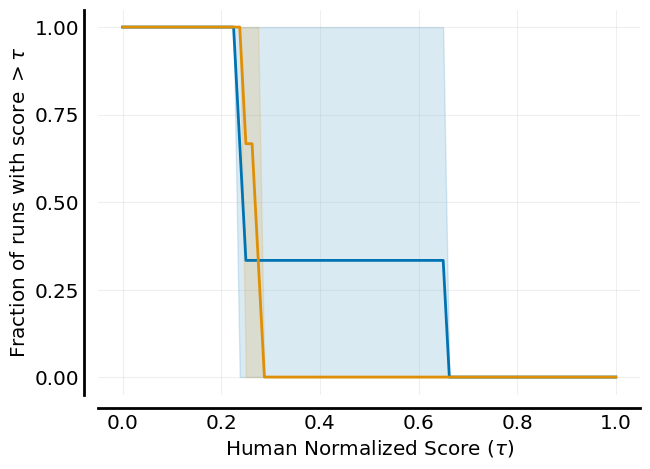

In [31]:
# Human normalized score thresholds
atari_200m_thresholds = np.linspace(0.0, 1.0, 81)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    scores_human, atari_200m_thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, atari_200m_thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algos, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)

<Axes: xlabel='Baseline Normalized Score $(\\tau)$', ylabel='Fraction of runs with score $> \\tau$'>

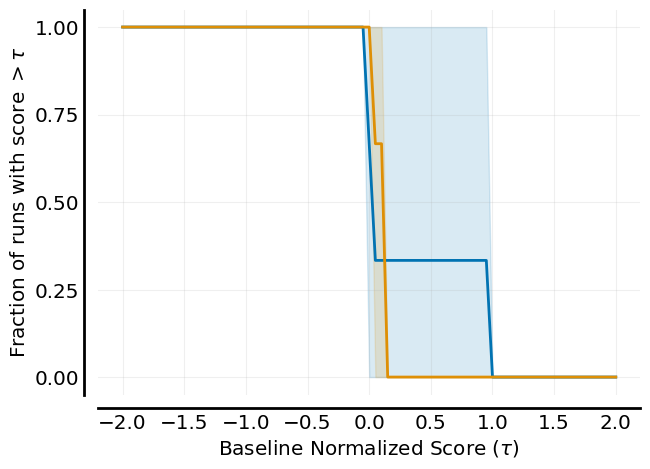

In [32]:
baseline_norm = lambda x: norm(x, mean_scores['baseline'].min(), mean_scores['baseline'].max())
scores_baseline = dict_loop(mean_scores, baseline_norm)

# Baseline normalized score thresholds
baseline_thresholds = np.linspace(-2., 2., 81)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    scores_baseline, baseline_thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, baseline_thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algos, sns.color_palette('colorblind'))),
  xlabel=r'Baseline Normalized Score $(\tau)$',
  ax=ax)

In [33]:
algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow',
              'IQN', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
ale_all_frames_scores_dict = ...
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in ale_all_frames_scores_dict.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  ale_frames_scores_dict, iqm, reps=50000)
plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score')

AttributeError: 'ellipsis' object has no attribute 'items'

In [34]:
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf, DictConfig

In [35]:
from pprint import pprint
from copy import deepcopy

In [37]:
with initialize(version_base=None, config_path=os.path.join(glob('final_output/*/*/cbp/seed1')[0], '.hydra')):
    hydra_cfg = compose('hydra', return_hydra_config=True)
    HydraConfig.instance().set_config(hydra_cfg)
    example_cfg = compose('config')
    OmegaConf.resolve(example_cfg.env)
    print(example_cfg.name)

cbp_seed1


In [38]:
pprint(dict(example_cfg))

{'algorithm': {'training_frames': 10000000, 'tensorboard_log': '${hydra:runtime.cwd}/${hydra:sweep.dir}/tensorboard', 'settings': {'policy': 'CnnPolicy', 'learning_starts': 80000, 'buffer_size': 1048576, 'batch_size': 256, 'target_update_interval': 32000, 'gradient_steps': 2, 'replay_buffer_kwargs': {'n_step': 3}, 'prioritized_er_beta0_initial': 0.45, 'gamma': 0.99, 'learning_rate': 0.00025, 'loss_fn': 'huber', 'max_grad_norm': 10, 'eps_decay_frames': 500000, 'policy_kwargs': {'noisy_linear': False, 'linear_kwargs': {}, 'optimizer_kwargs': {'betas': [0.9, 0.999], 'eps': None, 'rho': 1e-05, 'm': 1000}, 'features_extractor_kwargs': {'model_size': 2}, 'optimizer_class': 'CBP'}}, 'policy': 'CPPO_Policy'},
 'cbp_dir': './cbp',
 'cbp_log_freq': 100,
 'env': {'env_name': 'gym:Asteroids', 'parallel_envs': 64, 'time_limit': 108000, 'subproc_vecenv': True, 'frame_stack': 4, 'frame_skip': 4, 'grayscale': True, 'gamma': 0.99, 'resolution': [84, 84], 'save_dir': './videos', 'record_every': 3000, 'd

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [40]:
cbp_dir = os.path.join(glob('final_output/*/*/cbp/seed1')[0], example_cfg.cbp_dir)

In [41]:
get_iteration = lambda s: int(os.path.basename(s).split('_', 1)[0])

In [42]:
cbp_files = sorted(glob(os.path.join(cbp_dir, '*_age.pt')), key=get_iteration)

In [43]:
example_file = torch.load(cbp_files[-6])

In [44]:
example_file['value_0']

tensor([ 20076, 309139, 309139, 309139, 207773, 309139, 309139, 307316, 309139,
        309139, 309139, 309139, 309139,  82585, 309139, 129843, 309139, 309139,
          1341, 309139, 309139, 160164, 309139, 309139, 309139, 309139, 309139,
        309139, 294555,  18792, 309139, 309139, 309139, 309139, 309139, 309139,
         64179, 290711,  12305, 309139, 309139, 309139,    248, 303213, 309139,
         81800, 309139, 309139, 309139, 306079,  91005, 309139, 309139,  35099,
        177875, 309139, 309139, 309139, 144476, 309139, 309139, 309139, 303949,
         28154, 309139, 252208, 309139, 116806, 309139, 309139,  46354, 309139,
        309139, 309139, 177727, 309139, 309139, 309139, 309139, 309139,  48141,
        309139, 131268, 309139, 309139, 309139, 163152, 309139, 239964, 309139,
        116987, 309139, 309139, 309139,  52635, 120711, 259197,  18912, 309139,
        224508,   4949, 297786, 309139, 108334, 309139, 309139, 309139, 188052,
        207897, 309139, 309139, 309139, 

In [45]:
309139//10#*256

30913

In [57]:
bin_factor = 100

In [58]:
gradient = np.linspace(0,1,(get_iteration(cbp_files[-1])*2)//bin_factor)
age_progression = np.stack([np.vstack([gradient]*len(example_file['value_0']))]*len(example_file))

In [59]:
age_progression.shape

(2, 256, 3099)

In [61]:
names = list(example_file.keys())
for f in tqdm(cbp_files):
    resets = torch.load(f)
    iteration = get_iteration(f)
    binned_index = (iteration*2)//bin_factor
    for name, reset in resets.items():
        name_index = names.index(name)
        
        changed_indices = (reset <= 2).nonzero().view(-1).cpu().numpy()
        if binned_index > 0:
            age_progression[name_index, changed_indices, binned_index:] = gradient[None, None, :-binned_index]
        else:
            age_progression[name_index, changed_indices, binned_index:] = 0

100%|█████████████████████████████████████████████████████████████████████████████| 1683/1683 [00:02<00:00, 808.04it/s]


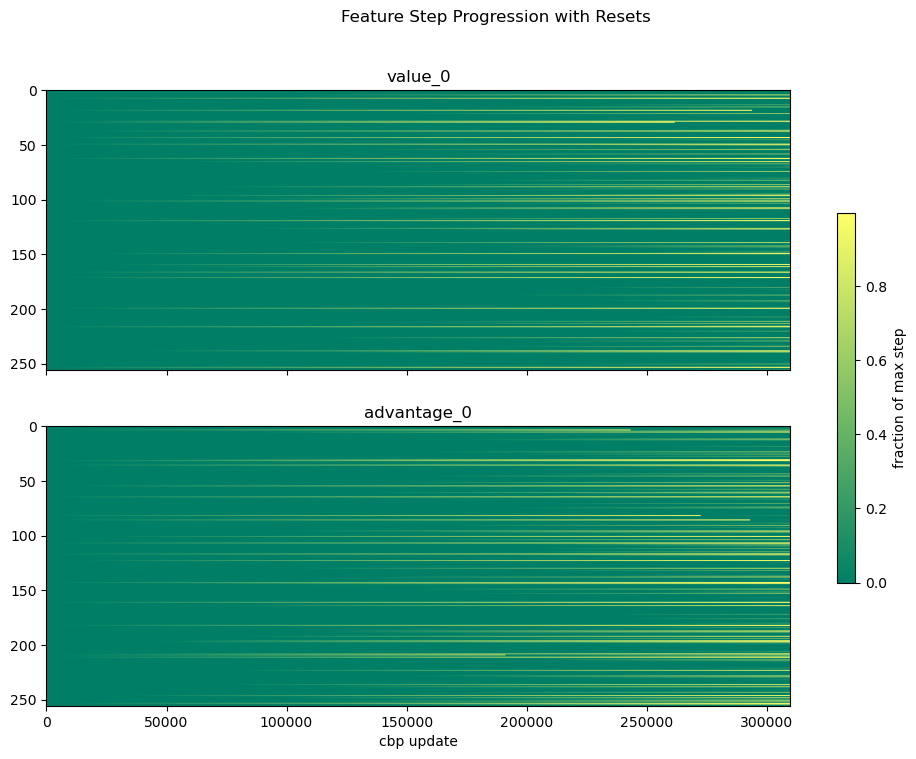

In [62]:
fig, axs = plt.subplots(len(names), sharex=True, figsize=(12, 8))
for i, (name, ax) in enumerate(zip(names, axs)):
    im = ax.imshow(age_progression[i], aspect='auto', cmap='summer')
    ax.set_title(name)
ticks = np.arange(0, age_progression.shape[-1], 500)
plt.xticks(ticks, ticks*bin_factor)
plt.xlabel('cbp update')
plt.colorbar(im, ax=axs, label='fraction of max step', shrink=0.6)
fig.suptitle('Feature Step Progression with Resets')
plt.show()

In [70]:
step_files = sorted(glob(os.path.join(cbp_dir, '*_step.pt')), key=get_iteration)
mean_step = np.arange(0, (get_iteration(step_files[-1])*2)//bin_factor)*bin_factor
for f in tqdm(step_files):
    steps = torch.load(f)
    iteration = get_iteration(f)
    binned_index = (iteration*2)//bin_factor
    
    # when new data comes in, we assume that from this point on until the next reset or the end, the steps will progress as if there are no resets, starting with the mean value of the current step file
    mean_step[binned_index:] = np.arange(0, len(mean_step) - binned_index)*10 + torch.cat(list(map(torch.flatten, steps.values()))).float().mean().cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████| 1682/1682 [06:16<00:00,  4.47it/s]


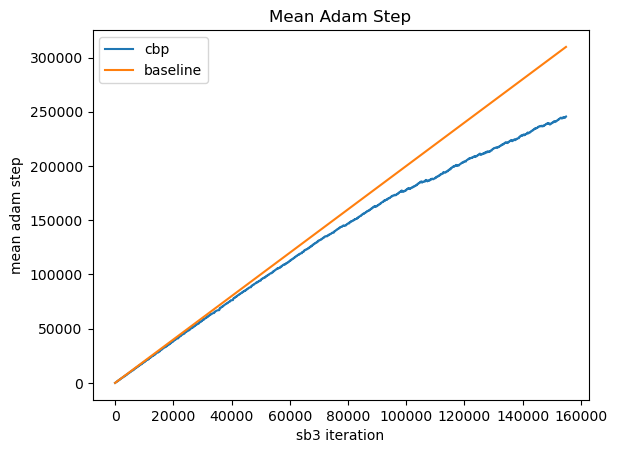

In [72]:
plt.plot(np.arange(0, len(mean_step))*bin_factor/2, mean_step, label='cbp')
plt.plot(np.arange(0, len(mean_step))*bin_factor/2, np.arange(0, len(mean_step))*bin_factor, label='baseline')
plt.title('Mean Adam Step')
plt.xlabel('sb3 iteration')
plt.ylabel('mean adam step')
plt.legend()
plt.show()

In [49]:
# one sb3 iteration does 2 gradient steps (per current config) and so corresponds to a step increase of 2

In [49]:
from rainbow import Rainbow
from run_utils import set_random, set_up_env, initialize_model

from stable_baselines3.common.evaluation import evaluate_policy

In [49]:
test_env_cfg = deepcopy(example_cfg.env)
test_env_cfg.decorr = False
test_env_cfg.seed = 4215247177   # generated using a numpy SeedSequence

In [51]:
test_env_cfg

{'env_name': 'gym:Breakout', 'parallel_envs': 64, 'time_limit': 108000, 'subproc_vecenv': False, 'frame_stack': 4, 'frame_skip': 4, 'grayscale': True, 'gamma': 0.99, 'resolution': [84, 84], 'save_dir': 'tmp', 'record_every': 3000, 'decorr': False, 'seed': 4215247177}

In [50]:
dummy_env_cfg = deepcopy(test_env_cfg)
dummy_env_cfg.seed = 1015279099
dummy_env_cfg.parallel_envs = 1

dummy_env = set_up_env(cfg.env)

In [52]:
dummy_env_cfg

{'env_name': 'gym:Breakout', 'parallel_envs': 1, 'time_limit': 108000, 'subproc_vecenv': False, 'frame_stack': 4, 'frame_skip': 4, 'grayscale': True, 'gamma': 0.99, 'resolution': [84, 84], 'save_dir': 'tmp', 'record_every': 3000, 'decorr': False, 'seed': 1015279099}

In [22]:
set_random(dummy_env_cfg.seed)

In [7]:
for alg in ['baseline', 'cbp']:
    runs = glob(os.path.join(base_path, alg, '*'))
    for run in runs:
        model = Rainbow.load(os.path.join(run, example_cfg.model_dir, 'final_model'), env=dummy_env)

In [1]:
from env_wrappers import create_env

In [5]:
class H():
    env_name= 'gym:Breakout'
    parallel_envs= 2
    time_limit= 108000
    subproc_vecenv= True
    frame_stack= 4
    frame_skip= 4
    grayscale= True
    gamma= 0.99
    resolution= [84, 84]
    save_dir= 'tmp'
    record_every= 3000
    decorr= True
    seed= 15279099

In [6]:
env = create_env(H(), decorr_steps=10)

In [11]:
s = env.reset()

In [12]:
j = env.step([env.action_space.sample()]*2)